Most of the contents of this notebook were prepared by Dr. Edward Raff (Spring 2019)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import polynomial_kernel


Before we start this lab, lets create a number of toy datasets to help us learn about the methods we are going to talk about. 2D toy datasets are helpful for us to learn from and get intuition since we can visualize. 

In [2]:
#First a linearly separable dataset, this will be the easiest 
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0,
                           n_classes=2, random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
linearly_separable_no_noise = (X, y)
X = X + 2 * rng.uniform(size=X.shape)   #we add noise to make it harder to separate linearly
linearly_separable = (X, y)

#make_moons and make_circles are built-in classes to create non-linearly separable datasets
toy_datasets = [
            linearly_separable_no_noise,
            linearly_separable,
            make_moons(noise=0.0, random_state=0),
            make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.0, factor=0.5, random_state=1),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            ]

#help(make_classification)

In [3]:

def plot_2d_examples(classifiers, names, datasets, figsize=(27,9), h = .02):
  """
  Here we define a helper method. We want to make a lot of visualizations, so lets 
  organize the visualization code into a method we can re-use. 
  - classifiers is a list of scikit-learn classifier objects
  - names is a list of strings, with the name we should use for each classifier in 'classifiers'. As such they should have the same length
  - datasets will be a list of 2D datasets, each being a tuple of (X, y)
  - h is the step size of the mesh. Smaller sizes show more detail
  """
  figure = plt.figure(figsize=figsize)
  i = 1
    
  # iterate over datasets
  for ds_cnt, ds in enumerate(datasets):
      # preprocess dataset, split into training and test part
      X, y = ds
      X = StandardScaler().fit_transform(X)
      X_train, X_test, y_train, y_test = \
          train_test_split(X, y, test_size=.4, random_state=42)

      x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
      y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
      xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))

      # just plot the dataset first
      cm = plt.cm.RdBu
      cm_bright = ListedColormap(['#FF0000', '#0000FF'])
      ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
      if ds_cnt == 0:
          ax.set_title("Input data")
      # Plot the training points
      ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                 edgecolors='k')
      # Plot the testing points
      ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
                 edgecolors='k')
      ax.set_xlim(xx.min(), xx.max())
      ax.set_ylim(yy.min(), yy.max())
      ax.set_xticks(())
      ax.set_yticks(())
      i += 1

      # iterate over classifiers
      for name, clf in zip(names, classifiers):
          ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
          clf.fit(X_train, y_train)
          score = clf.score(X_test, y_test)

          # Plot the decision boundary. For that, we will assign a color to each
          # point in the mesh [x_min, x_max]x[y_min, y_max].
          if hasattr(clf, "decision_function"):
              Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
          else:
              Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

          # Put the result into a color plot
          Z = Z.reshape(xx.shape)
          ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

          # Plot the training points
          ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                     edgecolors='k')
          # Plot the testing points
          ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                     edgecolors='k', alpha=0.6)

          ax.set_xlim(xx.min(), xx.max())
          ax.set_ylim(yy.min(), yy.max())
          ax.set_xticks(())
          ax.set_yticks(())
          if ds_cnt == 0:
              ax.set_title(name)
          ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                  size=15, horizontalalignment='right')
          i += 1

  plt.tight_layout()
  plt.show()

## k-NN

Lets start with the *k-Nearest Neighbor* algorithm, or *kNN*. 


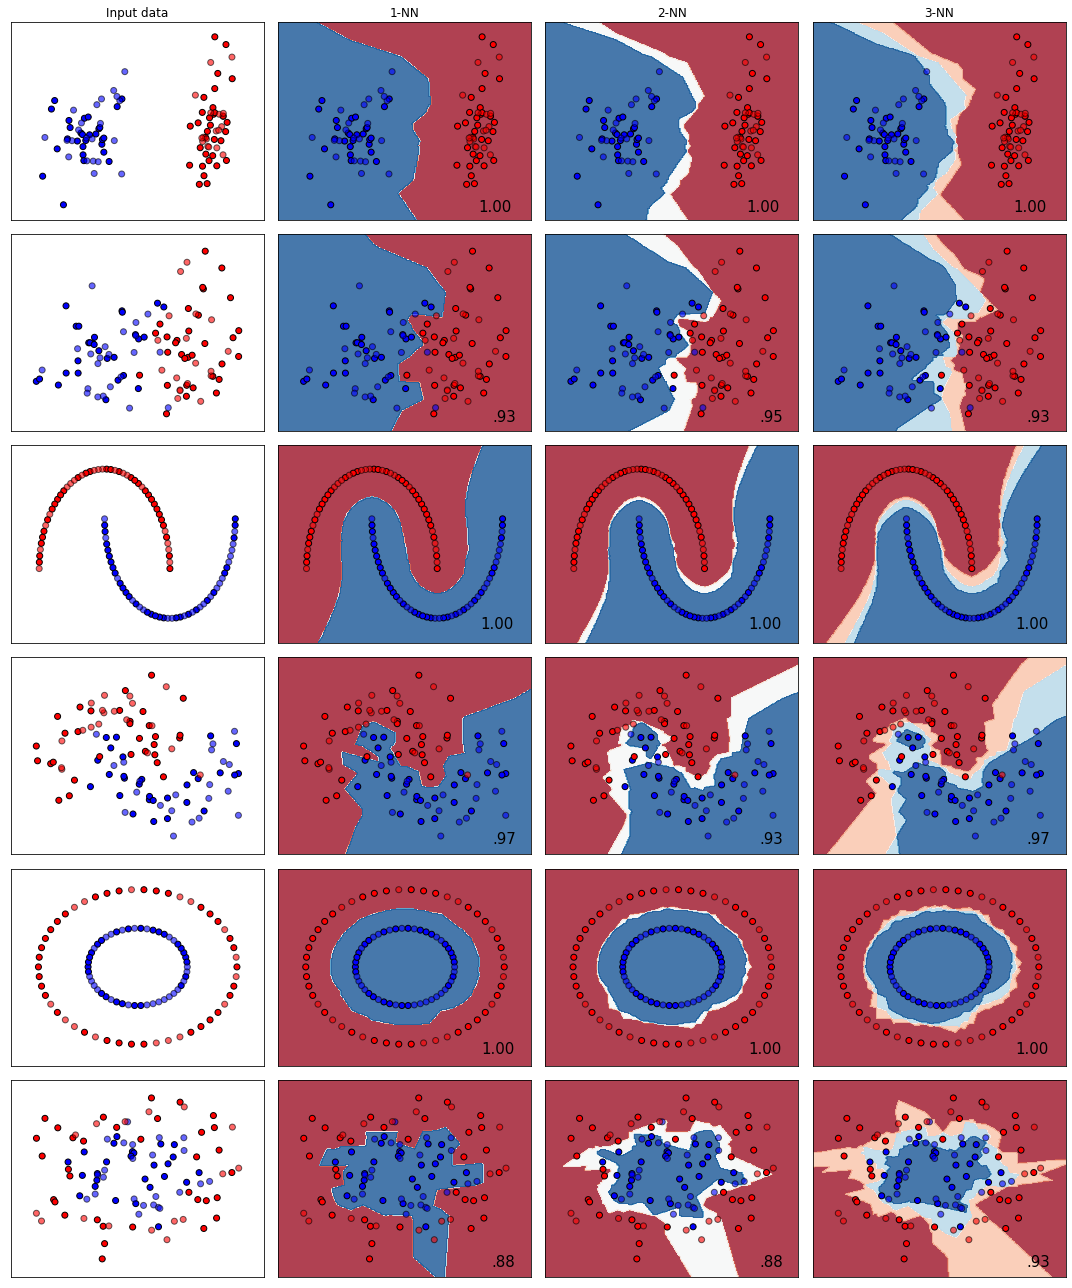

In [4]:
#First, lets visualize some results of applying k-nn on toy datasets.
classifiers = []
names = []

#for i in [1, 2, 3, 5, 9, 15, 30]:
for i in [1, 2, 3]: 
  classifiers.append(KNeighborsClassifier(n_neighbors=i))
  names.append(str(i)+"-NN")

#toy_datasets=[linearly_separable]
plot_2d_examples(classifiers, names, toy_datasets, figsize=(15,18))

When we try out different $k$ values, we can see that the number of neighbors $k$ acts as a regularizer, with increasing $k$ restricting the model's flexibility. It also has some uniqueness from a performance perspective. There is *no training time* to create a kNN model. Instead we put everything off to inference time. If we have $n$ datapoints in our training set and $d$ features, we need to do $O(n \cdot d)$ work on every prediction. This can make scaling up to larger datasets difficult! In parametric models (Naive Bayes, Logistic Regression, Decision Tree etc), we have something close to $O(n \cdot d)$ training time, but require only $O(d)$ time for inference.

In [5]:
#Lets import the time module so that we can see how long it takes to do things
import time

In [6]:
#help(KNeighborsClassifier)

In [7]:
classifiers = [ KNeighborsClassifier(algorithm="brute"), LogisticRegression(solver='liblinear') ]
names = ["5-NN (brute)       ",   #default is 5-NN
         "Logistic Regression"]

# Here, 'brute' indicates to use brute force to find the nearest neighbors
# There are some more efficient ways to do that like kd-trees.

for n in [2**10, 2**11, 2**12, 2**13, 2**14, 2**15]:
  print("Using n=", n, " training points")
  
  X, y = make_moons(n_samples=n, noise=0.3, random_state=0)
  
  for model, name in zip(classifiers, names):
    
    t = time.process_time()
    model.fit(X, y)
    fit_time = time.process_time() - t
    
    t = time.process_time()
    model.predict(X)
    inference_time = time.process_time() - t
    
    print("\t", name, " took ", fit_time, " to train and ", inference_time, " for inference of ",n, " samples")

Using n= 1024  training points
	 5-NN (brute)         took  0.0  to train and  0.3125  for inference of  1024  samples
	 Logistic Regression  took  0.0  to train and  0.0  for inference of  1024  samples
Using n= 2048  training points
	 5-NN (brute)         took  0.0  to train and  0.859375  for inference of  2048  samples
	 Logistic Regression  took  0.015625  to train and  0.0  for inference of  2048  samples
Using n= 4096  training points
	 5-NN (brute)         took  0.0  to train and  1.453125  for inference of  4096  samples
	 Logistic Regression  took  0.0  to train and  0.0  for inference of  4096  samples
Using n= 8192  training points
	 5-NN (brute)         took  0.0  to train and  4.0625  for inference of  8192  samples
	 Logistic Regression  took  0.0  to train and  0.0  for inference of  8192  samples
Using n= 16384  training points
	 5-NN (brute)         took  0.0  to train and  11.734375  for inference of  16384  samples
	 Logistic Regression  took  0.015625  to train and

##SVM

Support Vector Machines (SVM) is a parametric learning method, like Logistic Regression. Lets see if they perform in a similar fashion. 

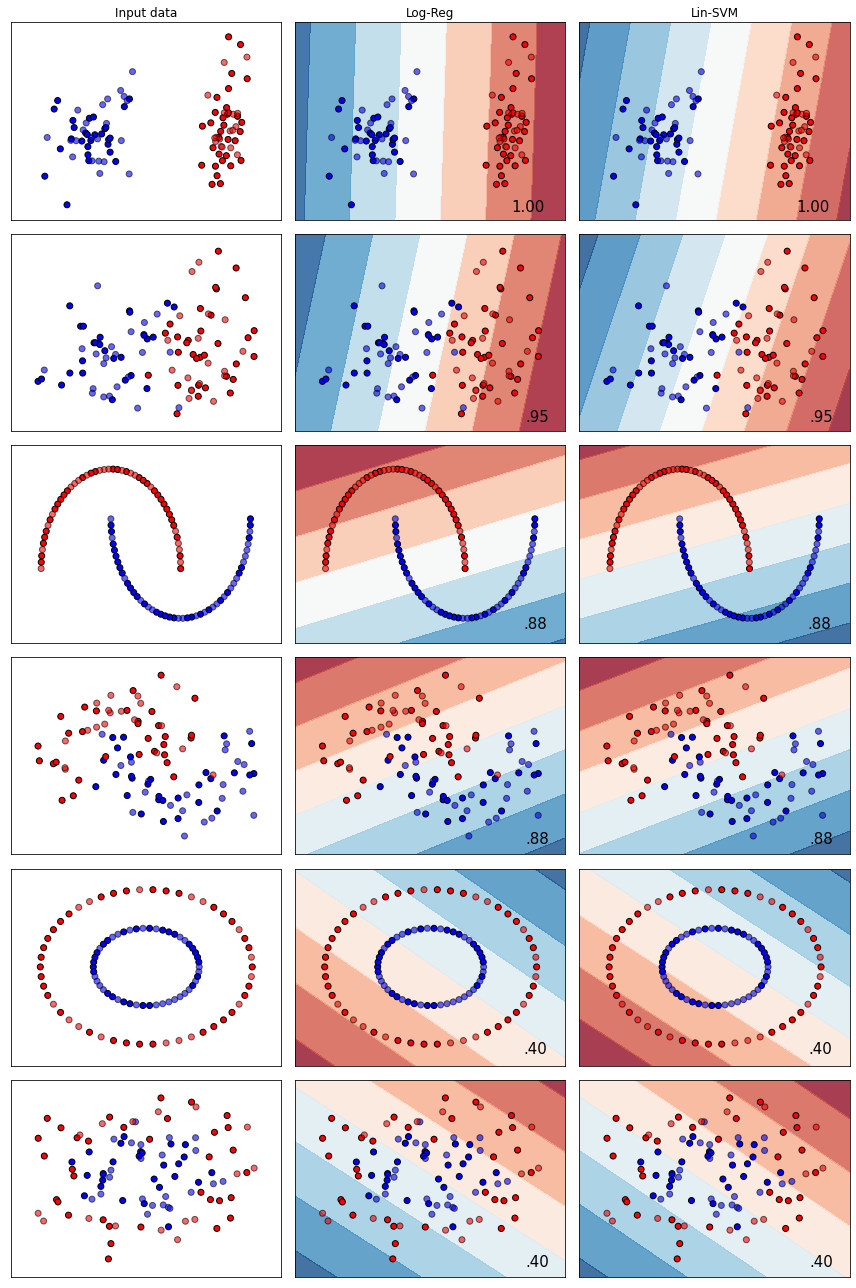

In [8]:
#Lets compare the two on our toy datasets
classifiers = [LogisticRegression(solver='liblinear'), LinearSVC()]
names = ["Log-Reg", "Lin-SVM"]

plot_2d_examples(classifiers, names, toy_datasets, figsize=(12,6*3))

SVM with linear kernel did not do any better then Logistic Regression. It is obvious that we need non-linear boundaries. In SVM, this is achieved via *kernel trick*.

Let's first investigate the *polynomial kernel* option:

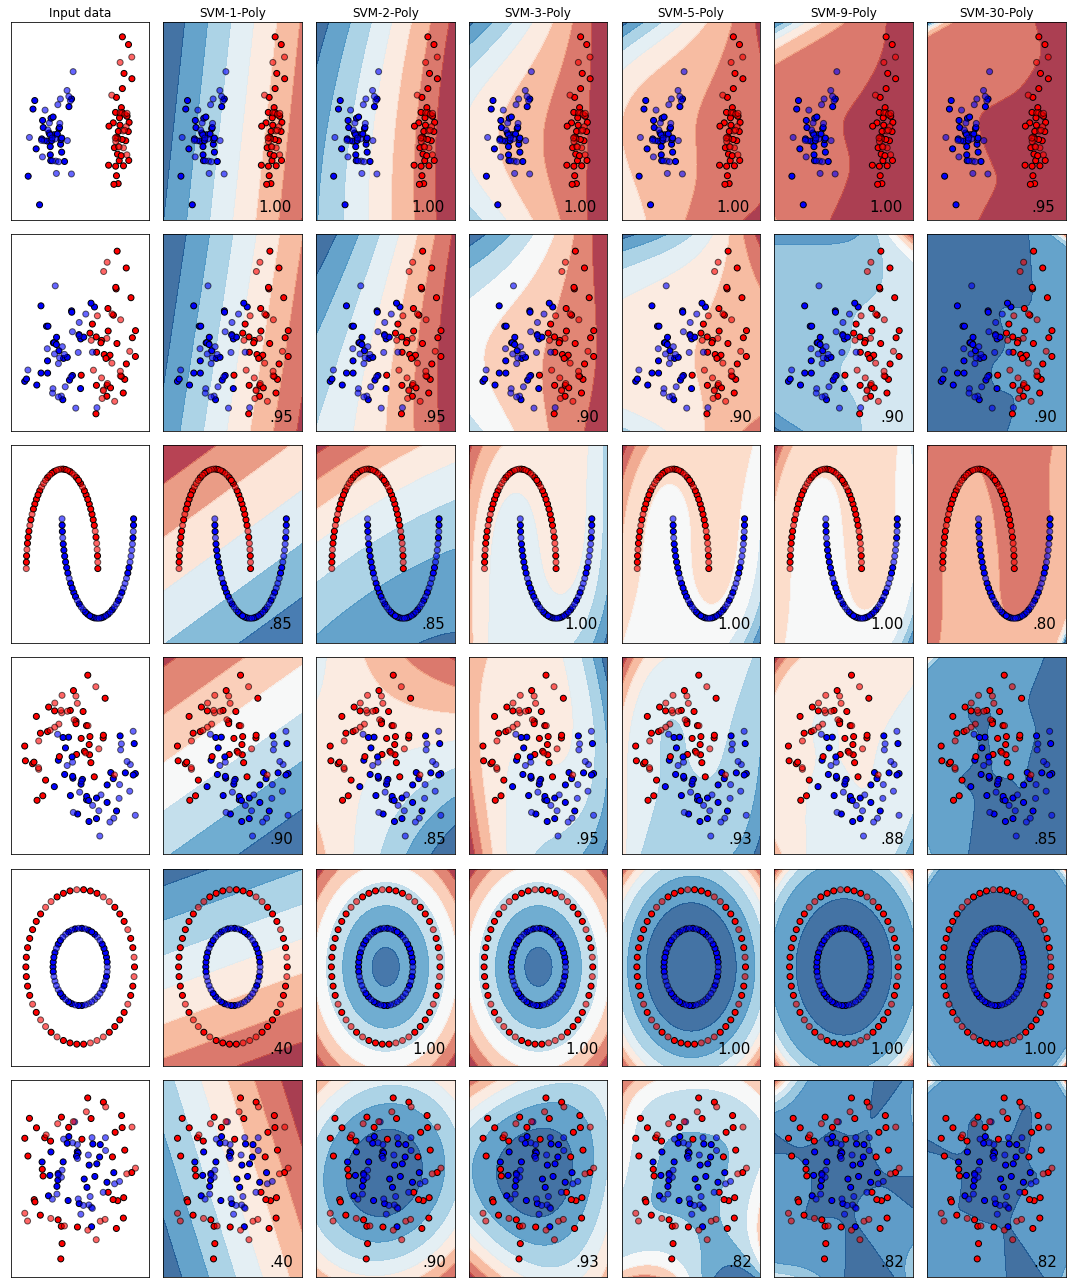

In [9]:
classifiers = []
names = []

for i in [1, 2, 3, 5, 9, 30]:
  classifiers.append(SVC(kernel='poly', degree=i, gamma='scale', coef0=1.0))
  names.append("SVM-"+str(i)+"-Poly")

plot_2d_examples(classifiers, names, toy_datasets, figsize=(15,6*3))

More popular than the *polynomial kernel* is the *Radial Basis Function (RBF) kernel*. Let's take a look at how well it does. 

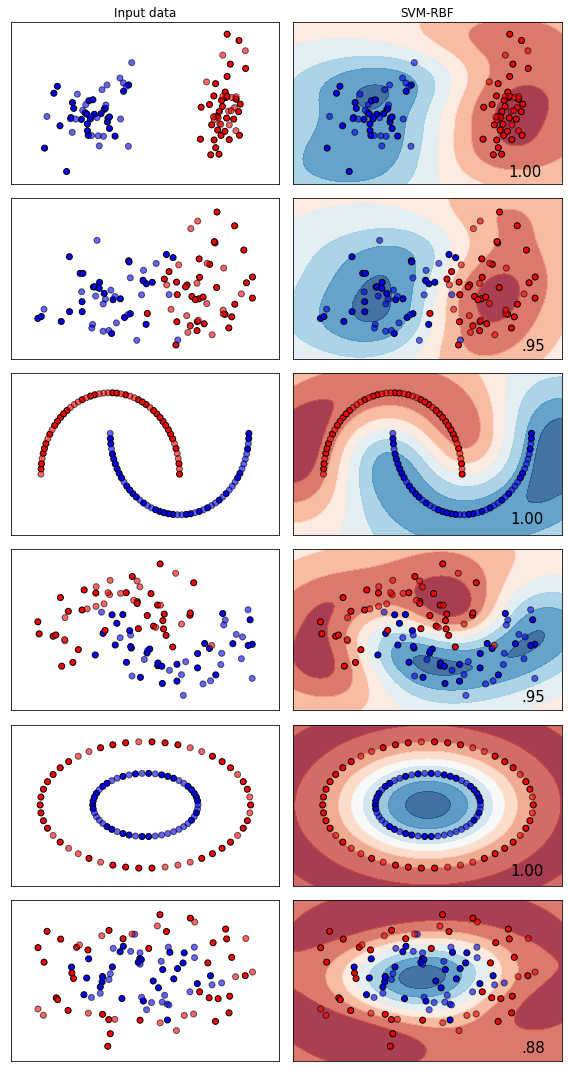

In [10]:
classifiers = [SVC(kernel='rbf', gamma='scale')]
names = ["SVM-RBF"]

plot_2d_examples(classifiers, names, toy_datasets, figsize=(8,5*3))

RBF kernel also has $\gamma$ parameter and it has a significant impact on the RBF kernel's behavior. Lets investigate:

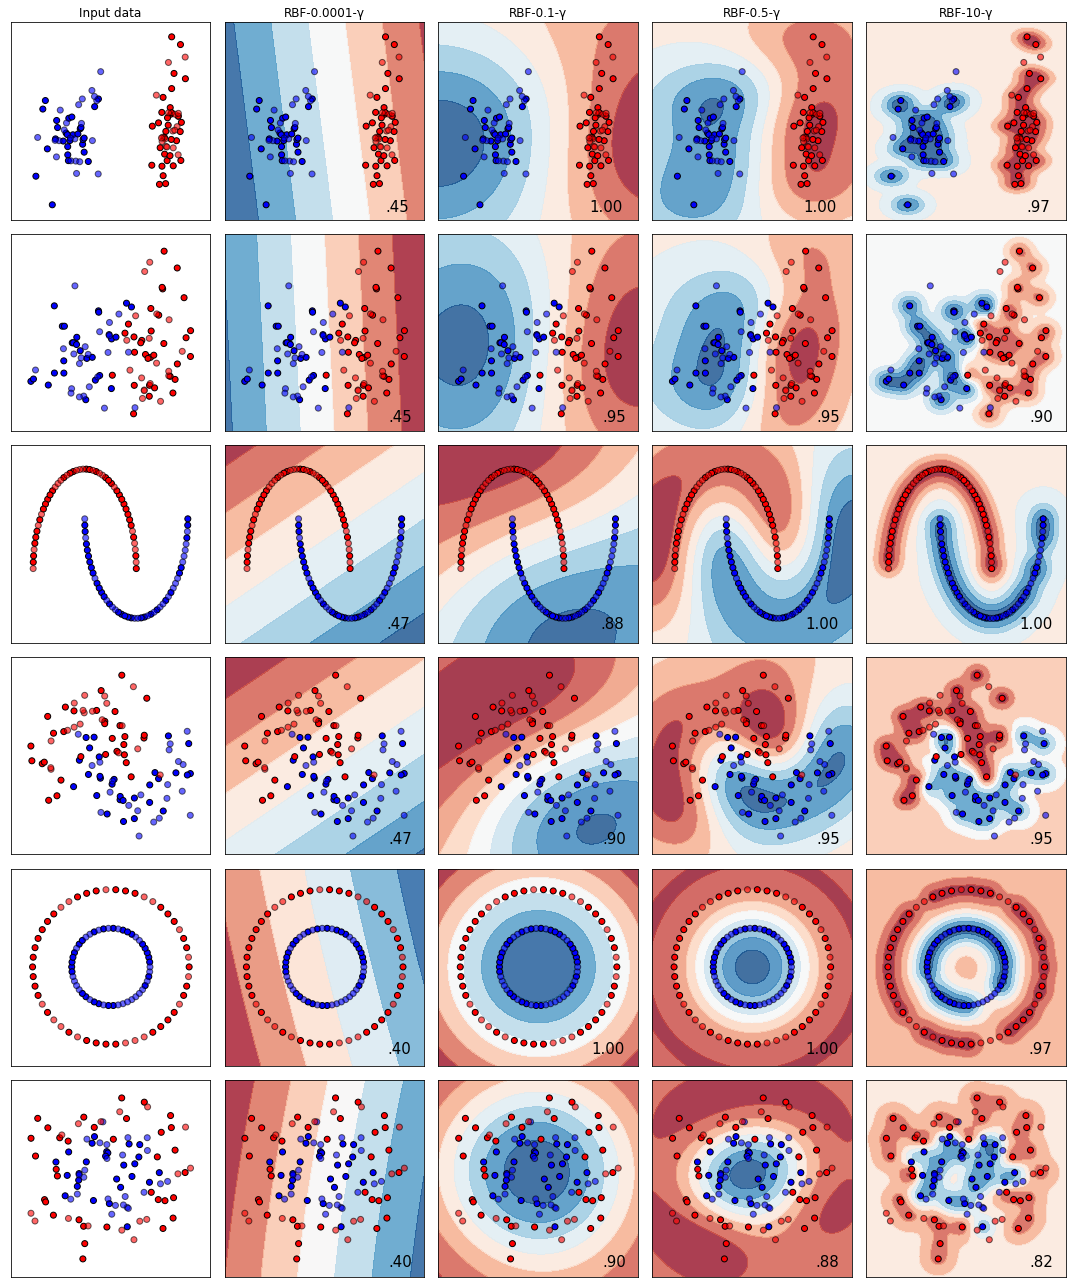

In [11]:
classifiers = []
names = []

for g in [0.0001, 0.1, 0.5, 10]:
  classifiers.append(SVC(kernel='rbf', gamma=g))
  names.append("RBF-"+str(g)+"-γ")

plot_2d_examples(classifiers, names, toy_datasets, figsize=(15,6*3))

SVMs are powerful, but also share some weaknesses. Linear kernel SVM training time is longer than Logistic Regression but comparable. However, for nonlinear kernels (see the results for RBF kernel below), training time increases fast with number of points. 

Inference time for nonlinear kernels is no more $O(d)$ but similar to kNN.

In [12]:
classifiers = [ LinearSVC(),
               SVC(kernel='rbf', gamma='scale') ]
names = ["Linear-SVM ", 
         "RBF-SVM    "]

for n in [2**10, 2**11, 2**12, 2**13, 2**14, 2**15]:
  print("Using n=", n, " training points")
  
  X, y = make_moons(n_samples=n, noise=0.3, random_state=0)
  
  for model, name in zip(classifiers, names):
    
    t = time.process_time()
    model.fit(X, y)
    fit_time = time.process_time() - t
    
    t = time.process_time()
    model.predict(X)
    inference_time = time.process_time() - t
    
    print("\t", name, " took ", fit_time, " to train and ", inference_time, " for inference of ",n,"samples")

Using n= 1024  training points
	 Linear-SVM   took  0.015625  to train and  0.0  for inference of  1024 samples
	 RBF-SVM      took  0.03125  to train and  0.046875  for inference of  1024 samples
Using n= 2048  training points
	 Linear-SVM   took  0.015625  to train and  0.0  for inference of  2048 samples
	 RBF-SVM      took  0.09375  to train and  0.15625  for inference of  2048 samples
Using n= 4096  training points
	 Linear-SVM   took  0.03125  to train and  0.0  for inference of  4096 samples
	 RBF-SVM      took  0.296875  to train and  0.53125  for inference of  4096 samples
Using n= 8192  training points
	 Linear-SVM   took  0.046875  to train and  0.0  for inference of  8192 samples
	 RBF-SVM      took  1.9375  to train and  2.09375  for inference of  8192 samples
Using n= 16384  training points
	 Linear-SVM   took  0.09375  to train and  0.0  for inference of  16384 samples
	 RBF-SVM      took  5.90625  to train and  8.4375  for inference of  16384 samples
Using n= 32768  tra

Another example that visualizes *support vectors*. 

C:\Users\pragathi\AppData\Local\Temp/ipykernel_9912/1206010722.py:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
C:\Users\pragathi\AppData\Local\Temp/ipykernel_9912/1206010722.py:52: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
C:\Users\pragathi\AppData\Local\Temp/ipykernel_9912/1206010722.py:52: MatplotlibDeprecationWarning: shading='flat' when X and Y ha

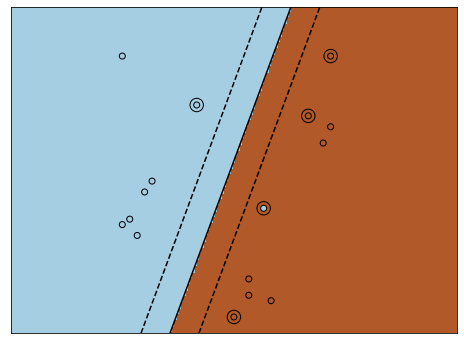

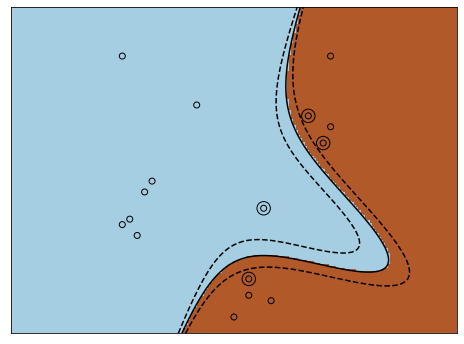

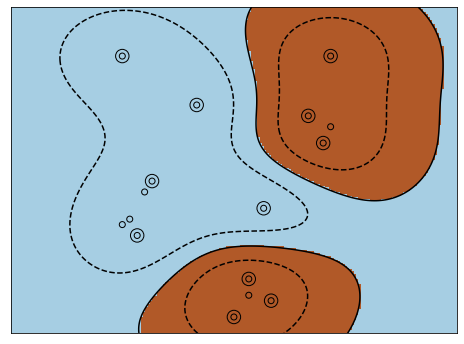

In [13]:
#stolen with love from https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py 

# Our dataset and targets
X = np.c_[(.4, -.7),
          (-1.5, -1),
          (-1.4, -.9),
          (-1.3, -1.2),
          (-1.1, -.2),
          (-1.2, -.4),
          (-.5, 1.2),
          (-1.5, 2.1),
          (1, 1),
          # --
          (1.3, .8),
          (1.2, .5),
          (.2, -2),
          (.5, -2.4),
          (.2, -2.3),
          (0, -2.7),
          (1.3, 2.1)].T
Y = [0] * 8 + [1] * 8

# figure number
fignum = 1

# fit the model
for kernel in ('linear', 'poly', 'rbf'):
    clf = SVC(kernel=kernel, gamma=1, C=1)
    clf.fit(X, Y)

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(8, 6))
    plt.clf()

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=180,
                facecolors='none', zorder=10, edgecolors='k')   #we put extra circle to support vectors
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,
                edgecolors='k')

    plt.axis('tight')
    x_min = -3
    x_max = 3
    y_min = -3
    y_max = 3

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(8, 6))
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1
plt.show()

## Let's see performance on a real dataset, digits data.

In [14]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [15]:
digits.data.shape

(1797, 64)

In [16]:
import pandas as pd 

pd.Series(digits.target).value_counts().sort_index()

0    178
1    182
2    177
3    183
4    181
5    182
6    181
7    179
8    174
9    180
dtype: int64

Almost perfectly balanced, multi-class dataset.

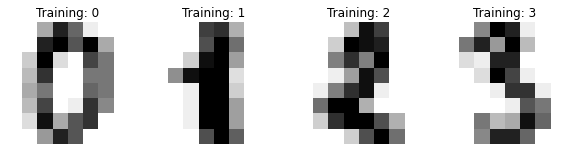

In [17]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

Still need to split off the data for training and evaluation.

In [18]:
from sklearn.model_selection import train_test_split

def create_splits(X, y):
    return train_test_split(X, y, test_size=0.20)

dX_train, dX_test, dy_train, dy_test = create_splits(digits.data, digits.target)

print(f'Training sample: {dX_train.shape[0]:,}')
print(f'Test sample: {dX_test.shape[0]:,}')

Training sample: 1,437
Test sample: 360


#### Logistic Regression
- We'll test using a few different regularization levels.  
- Labels are balanced, so accuracy is a reasonable choice for a metric.  

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

lg_reg = modeling_pipeline = Pipeline([('scaling', StandardScaler()),
                                       ('model', LogisticRegression(solver='liblinear'))])

param_grid = [
  {'model__C': [0.01, 0.1, 1, 10, 100, 1000]}
 ]

lg_results = GridSearchCV(estimator=lg_reg, param_grid=param_grid, scoring='accuracy', refit=True, cv=5)
lg_results = lg_results.fit(dX_train, dy_train)

ConfusionMatrixDisplay.from_estimator(lg_results, dX_test, dy_test)
plt.show()

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_estimator'

In [20]:
lg_results.best_estimator_

Pipeline(steps=[('scaling', StandardScaler()),
                ('model', LogisticRegression(C=1, solver='liblinear'))])

#### Support Vector Machine
We'll try using a few different regularization options and two different kernels.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

svm_m = modeling_pipeline = Pipeline([('scaling', StandardScaler()),
                                       ('model', SVC())])

param_grid = [
  {'model__C': [0.01, 0.1, 1, 10, 100, 1000], 'model__kernel': ['linear','rbf']}

 ]

svm_results = GridSearchCV(estimator=svm_m, param_grid=param_grid, scoring='accuracy', refit=True, cv=5)
svm_results = svm_results.fit(dX_train, dy_train)

ConfusionMatrixDisplay.from_estimator(svm_results, dX_test, dy_test)
plt.show()

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_estimator'

In [22]:
svm_score = svm_results.score(dX_test, dy_test)
lreg_score = lg_results.score(dX_test, dy_test)

print(f'Logistic Regression Score: {lreg_score:.2%}')
print(f'Support Vector Machine Score: {svm_score:.2%}')

Logistic Regression Score: 96.39%
Support Vector Machine Score: 98.61%


> Marginally better performance with the Support Vector Machine, with the below hyperparameters:

In [23]:
print('\n Best params: ', svm_results.best_params_)

#svm_results.best_estimator_


 Best params:  {'model__C': 0.1, 'model__kernel': 'linear'}


#### kNN on the Digits Data

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

knn_m = modeling_pipeline = Pipeline([('scaling', StandardScaler()),
                                       ('model', KNeighborsClassifier())])


param_grid = [
  {'model__n_neighbors': [1, 4, 7, 10, 13], 'model__weights': ['uniform','distance']}
 ]

knn_results = GridSearchCV(estimator=knn_m, param_grid=param_grid, scoring='accuracy', refit=True, cv=5)
knn_results = knn_results.fit(dX_train, dy_train)

ConfusionMatrixDisplay.from_estimator(knn_results, dX_test, dy_test)
plt.show()

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_estimator'

In [25]:
svm_score = svm_results.score(dX_test, dy_test)
lreg_score = lg_results.score(dX_test, dy_test)
knn_score = knn_results.score(dX_test, dy_test)

print(f'Logistic Regression Score: {lreg_score:.2%}')
print(f'Support Vector Machine Score: {svm_score:.2%}')
print(f'k-Nearest Neighbor Score: {knn_score:.2%}')

Logistic Regression Score: 96.39%
Support Vector Machine Score: 98.61%
k-Nearest Neighbor Score: 99.17%


In [26]:
knn_results.best_estimator_
#help(KNeighborsClassifier)

Pipeline(steps=[('scaling', StandardScaler()),
                ('model',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))])

# Homework 4 (due 20th July, 11:59 PM)

1.  Use Iris dataset with only two features, namely petal length (cm) and petal width (cm).
2.  Convert your data into a two-class dataset, such that Virginica (class=2) will be one class and Setosa and Versicolor (class=1 and class=0) samples will constitute the other class.
3.  Get your new dataset ready to be fed into the provided plot_2d_examples function.
4.  Using plot_2d_examples function, evaluate different SVM classifiers with polynomial kernels of varying degrees. Also, try several $C$ values.





You should be able to get some figures like this:

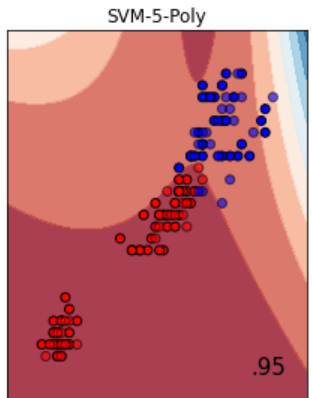

5.  Do not separate the train/test sets by yourselves, just feed into plot_2d_examples. It has its own split inside. Also it prints test set scores on the bottom corner of each figure. According to these scores, which (degree,$C$) pair produced the best results? Please indicate your answer explicitly.
6.  Also comment on $C$ values. Which $C$ value range is reasonable do you think? After which value, it looks like an overfit?

### 1.  Use Iris dataset with only two features, namely petal length (cm) and petal width (cm)

In [27]:
# loading the iris data set
data= datasets.load_iris()

In [28]:
data

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [29]:
df = pd.DataFrame(data=np.c_[data['data'], data['target']],columns= list(data['feature_names']) + ['target'])
display(df)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [30]:
df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

In [31]:
#using only petal width and petal length from the iris dataset
df1=df[['petal length (cm)', 'petal width (cm)','target']]

In [32]:
df1

,petal length (cm),petal width (cm),target
0,1.4,0.2,0.0
1,1.4,0.2,0.0
2,1.3,0.2,0.0
3,1.5,0.2,0.0
4,1.4,0.2,0.0
...,...,...,...
145,5.2,2.3,2.0
146,5.0,1.9,2.0
147,5.2,2.0,2.0
148,5.4,2.3,2.0


### 2.  Convert your data into a two-class dataset, such that Virginica (class=2) will be one class and Setosa and Versicolor (class=1 and class=0) samples will constitute the other class.

In [33]:
#converting iris data into 2 class dataset by replacing the target class=0 with 1
df1['target'] = df1['target'].replace(0,1)

C:\Users\pragathi\AppData\Local\Temp/ipykernel_9912/903427233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['target'] = df1['target'].replace(0,1)


In [34]:
df1  # now there are only 2 target classes in the iris data they are 1 and 2

,petal length (cm),petal width (cm),target
0,1.4,0.2,1.0
1,1.4,0.2,1.0
2,1.3,0.2,1.0
3,1.5,0.2,1.0
4,1.4,0.2,1.0
...,...,...,...
145,5.2,2.3,2.0
146,5.0,1.9,2.0
147,5.2,2.0,2.0
148,5.4,2.3,2.0


<AxesSubplot:xlabel='petal length (cm)', ylabel='petal width (cm)'>

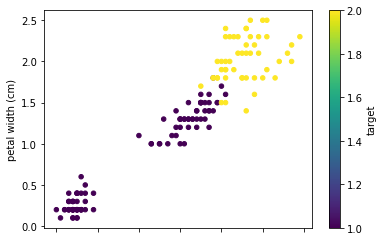

In [35]:
df1.plot.scatter(x='petal length (cm)',y='petal width (cm)',c='target',colormap='viridis')

### 3.  Get your new dataset ready to be fed into the provided plot_2d_examples function.

In [36]:
X = df1.drop(columns = ['target'])
y = df1['target']
X.to_numpy()
y.to_numpy()
iris_data = (X, y)
data = [iris_data]

### 4.  Using plot_2d_examples function, evaluate different SVM classifiers with polynomial kernels of varying degrees. Also, try several $C$ values.

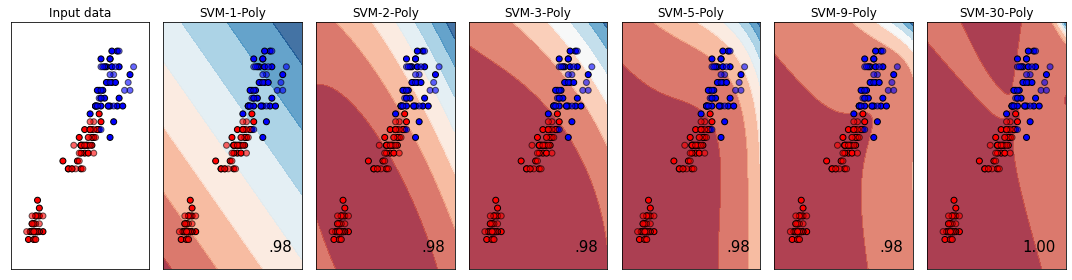

In [37]:
classifiers = []
names = []

for i in [1, 2, 3, 5, 9, 30]:
  classifiers.append(SVC(kernel='poly', degree=i, gamma='scale', coef0=1.0))
  names.append("SVM-"+str(i)+"-Poly")

plot_2d_examples(classifiers, names, data, figsize=(15,4))

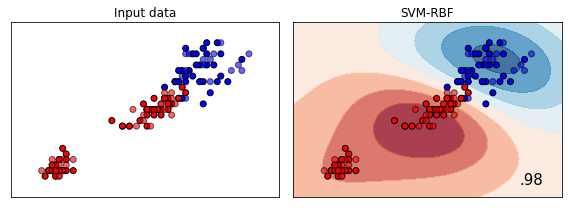

In [38]:
classifiers = [SVC(kernel='rbf', gamma='scale',degree=1,C=1)]
names = ["SVM-RBF"]

plot_2d_examples(classifiers, names,data, figsize=(8,3))

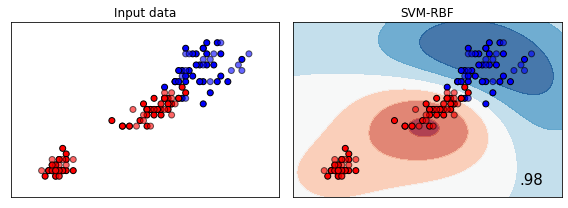

In [39]:
classifiers = [SVC(kernel='rbf', gamma='scale',degree=1,C=5)]
names = ["SVM-RBF"]

plot_2d_examples(classifiers, names, data, figsize=(8,3))

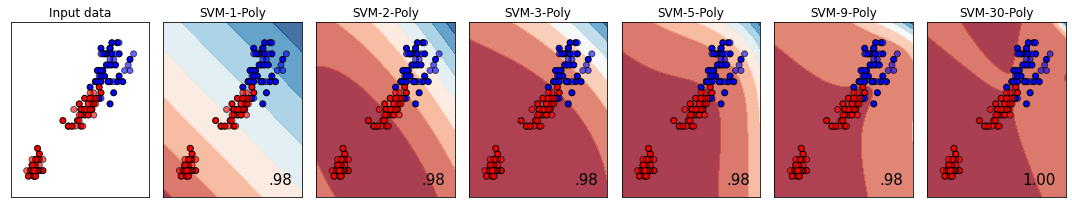

In [40]:
classifiers = []
names = []

for i in [1, 2, 3, 5, 9, 30]:
  classifiers.append(SVC(kernel='poly', degree=i, gamma='scale', coef0=1.0))
  names.append("SVM-"+str(i)+"-Poly")

plot_2d_examples(classifiers, names, data, figsize=(15,3))

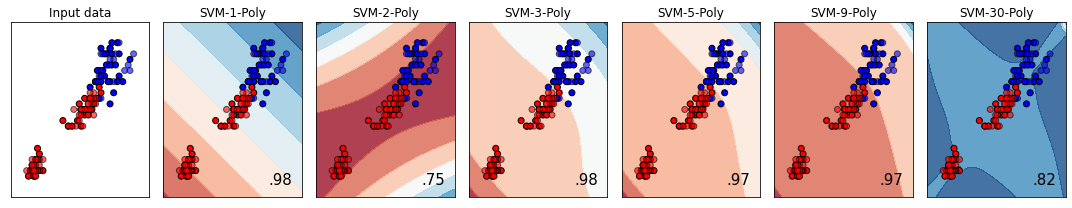

In [41]:
classifiers = []
names = []

for i in [1, 2, 3, 5, 9, 30]:
  classifiers.append(SVC(kernel='poly', degree=i, gamma='scale', C=5))
  names.append("SVM-"+str(i)+"-Poly")

plot_2d_examples(classifiers, names, data, figsize=(15,3))

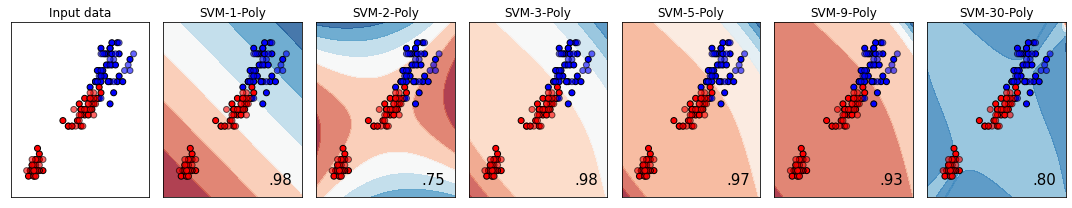

In [42]:
classifiers = []
names = []

for i in [1, 2, 3, 5, 9, 30]:
  classifiers.append(SVC(kernel='poly', degree=i, gamma='scale', C=0.9))
  names.append("SVM-"+str(i)+"-Poly")

plot_2d_examples(classifiers, names, data, figsize=(15,3))

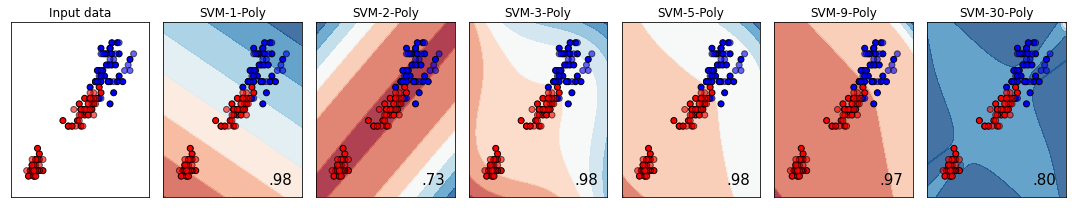

In [43]:
classifiers = []
names = []

for i in [1, 2, 3, 5, 9, 30]:
  classifiers.append(SVC(kernel='poly', degree=i, gamma='scale', C=50))
  names.append("SVM-"+str(i)+"-Poly")

plot_2d_examples(classifiers, names, data, figsize=(15,3))

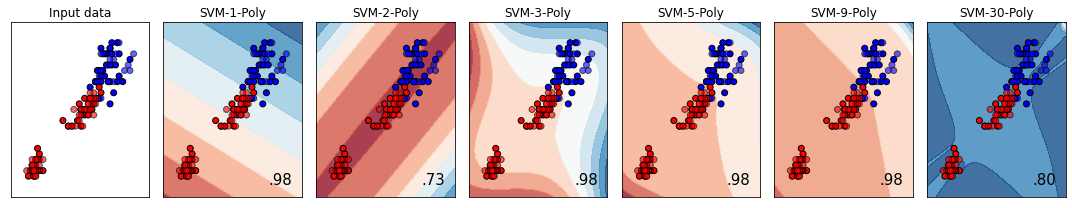

In [44]:
classifiers = []
names = []

for i in [1, 2, 3, 5, 9, 30]:
  classifiers.append(SVC(kernel='poly', degree=i, gamma='scale', C=100))
  names.append("SVM-"+str(i)+"-Poly")

plot_2d_examples(classifiers, names, data, figsize=(15,3))

### degree=3,C=5 pair produced the best score for SVM i.e 98%.

### i have tried different C values like0.9,1,5,50,100 for different degrees like 1,2,3,5,9,30 from the results obtained i understood that as we increase the C value the graphs are becomming over fitting which resultes in increasing the SVM score.i think that smaller C values will give accurate scores.for C values less than 10 we are getting perfect scores.for C greater than 10 the values are over fitting.

### ref:https://medium.com/@pinnzonandres/iris-classification-with-svm-on-python-c1b6e833522c